# Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
import pickle
import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from numpy.random import rand
import cv2
from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle
from skimage.color import rgb2gray
from tensorflow.contrib.layers import flatten
import tensorflow as tf
import matplotlib.image as mpimg
import glob


In [2]:
training_file = '../data/train.p'
validation_file='../data/valid.p'
testing_file = '../data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES** 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Use python, pandas or numpy methods rather than hard coding the results

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# Shape of an traffic sign image
image_shape = X_train[0].shape

# Unique classes/labels are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Visualization of the dataset

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.



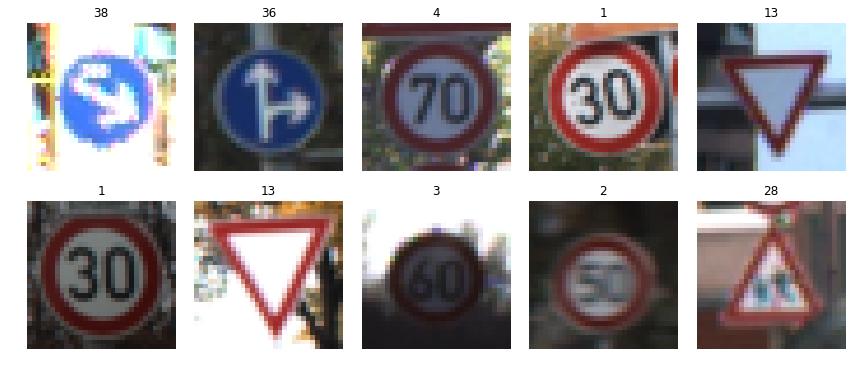

In [4]:
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])

In [5]:
class_count = np.zeros(n_classes)
for i in range(len(X_train)):
    class_count[y_train[i]] += 1

Text(0.5,1,'Distribution of Classes in Training Set')

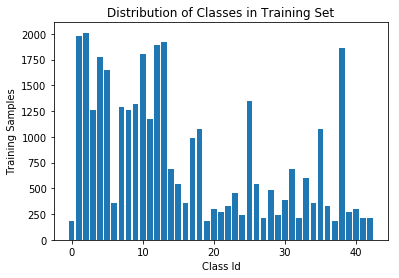

In [6]:
classes = [i for i in range(n_classes)]
plt.bar(classes, class_count)
plt.xlabel('Class Id')
plt.ylabel('Training Samples')
plt.title('Distribution of Classes in Training Set')

Text(0.5,1,'Distribution of Classes in Training Set')

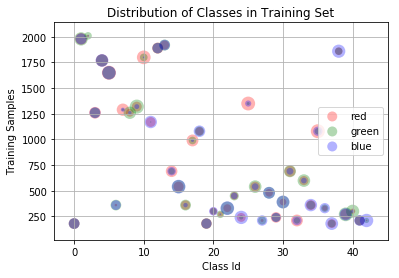

In [7]:
fig, ax = plt.subplots()
for color in ['red', 'green', 'blue']:
    n = 750
    scale = 200.0 * rand(n)
    ax.scatter(classes, class_count, c=color, s=scale, label=color,
               alpha=0.3, edgecolors='none')

ax.legend()
ax.grid(True)
plt.xlabel('Class Id')
plt.ylabel('Training Samples')
plt.title('Distribution of Classes in Training Set')

In [8]:
signnames = pd.read_csv('./signnames.csv')
signnames.set_index('ClassId',inplace=True)


def get_signname_from_label(label):
    # Helper, transofrm a numeric label into the corresponding strring
    return signnames.loc[label].SignName

In [9]:
counter = Counter(y_train)
print("Train example per class mean {} min {} max {}".format(int(np.mean(list(Counter(y_train).values()))),
                                                    np.min(list(Counter(y_train).values())) ,
                                                    np.max(list(Counter(y_train).values())) ))
print()
print("Most common signs:")
for el in counter.most_common(10):
    print("'{}'".format(get_signname_from_label(el[0])),' train samples: {}'.format(el[1]))
print()
print("Most rare signs:")
for el in sorted(counter.items(),key=lambda x: x[1])[:10]:
    print("'{}'".format(get_signname_from_label(el[0])),' train samples: {}'.format(el[1]))



Train example per class mean 809 min 180 max 2010

Most common signs:
'Speed limit (50km/h)'  train samples: 2010
'Speed limit (30km/h)'  train samples: 1980
'Yield'  train samples: 1920
'Priority road'  train samples: 1890
'Keep right'  train samples: 1860
'No passing for vehicles over 3.5 metric tons'  train samples: 1800
'Speed limit (70km/h)'  train samples: 1770
'Speed limit (80km/h)'  train samples: 1650
'Road work'  train samples: 1350
'No passing'  train samples: 1320

Most rare signs:
'Go straight or left'  train samples: 180
'Dangerous curve to the left'  train samples: 180
'Speed limit (20km/h)'  train samples: 180
'End of no passing'  train samples: 210
'End of no passing by vehicles over 3.5 metric tons'  train samples: 210
'End of all speed and passing limits'  train samples: 210
'Pedestrians'  train samples: 210
'Bicycles crossing'  train samples: 240
'Road narrows on the right'  train samples: 240
'Keep left'  train samples: 270


In [9]:
counts = pd.DataFrame(columns=['sign_label','training_samples_count'],data=[(label, count) for label, count in counter.items()])
counts['sign'] = counts.sign_label.apply(get_signname_from_label)

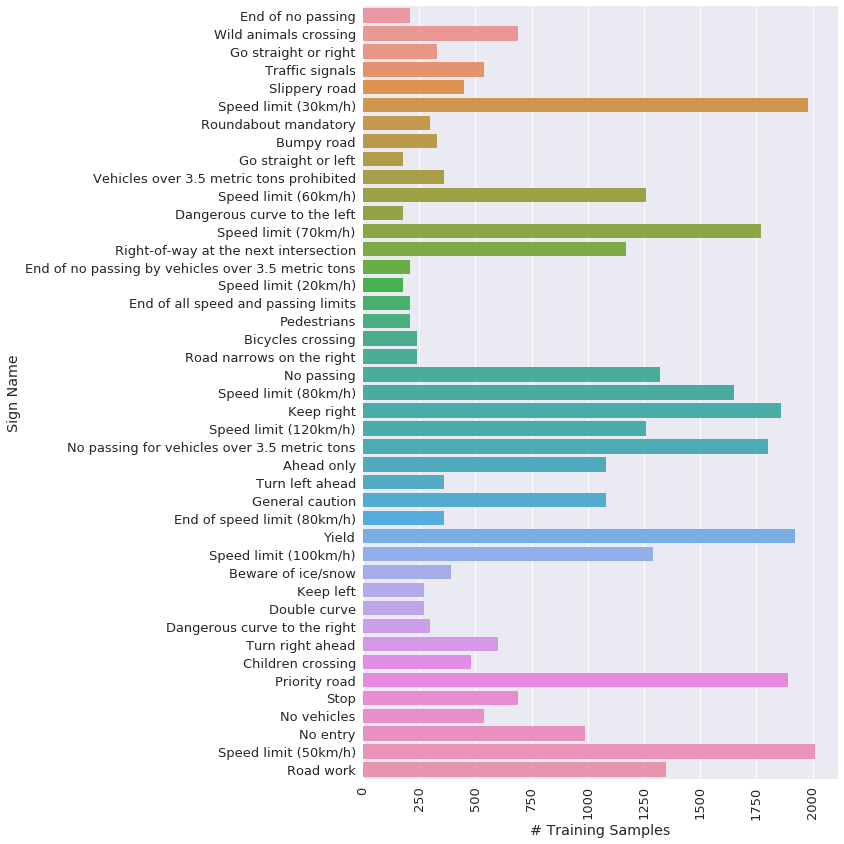

In [10]:
plt.figure(figsize=(12,12))
sns.set(font_scale=1.3)
sns.barplot(x='training_samples_count',y='sign',data=counts,orient='o')
plt.xticks(rotation=90)
plt.ylabel('Sign Name')
plt.xlabel('# Training Samples');
plt.tight_layout()

In [10]:
low_image_classes = [i for i, j in enumerate(class_count) if j<500]
print('Number of classes with low images :',len(low_image_classes))
print(low_image_classes)

Number of classes with low images : 21
[0, 6, 16, 19, 20, 21, 22, 23, 24, 27, 28, 29, 30, 32, 34, 36, 37, 39, 40, 41, 42]


Classes with low images:
Total low images:  6060


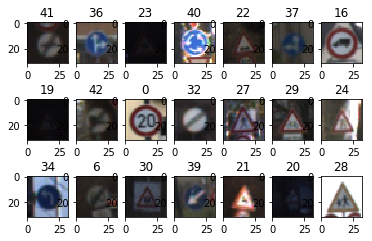

In [11]:
temp = []
t=1
num = 0
print('Classes with low images:')
for i, j in enumerate(y_train):
    if(j in low_image_classes):
        num += 1
        if not(y_train[i] in temp):
            plt.subplot(3, 7, t)
            t += 1
            plt.title(y_train[i])
            plt.imshow(X_train[i])
            temp.append(y_train[i])
print('Total low images: ', num)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

## LeNet 
![LeNet Architecture](lenet.png)
Source: [Yan LeCun](http://yann.lecun.com/exdb/lenet/)

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf).

### Pre-process the Data Set (normalization, grayscale, etc.)

1. Apply normalization filter (cv.NORM_MINMAX) for all datasets.
2. Apply grayscale filter for all datasets.
3. Shuffle the training data.

(34799, 32, 32, 3)
(34799, 32, 32)
(12630, 32, 32, 3)
(12630, 32, 32)
(4410, 32, 32, 3)
(4410, 32, 32)


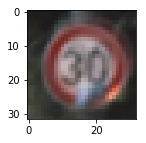

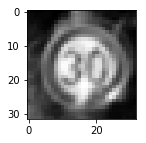

In [12]:
def normalize(img):
    return cv2.normalize(img, img, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
def grayscale(img):
    return rgb2gray(img)

def setgrayscale(images):
    #from rgb to gray
    print(images.shape)
    result = np.zeros(shape=(len(images),32,32))
    for i in range(len(images)): 
        gray_img = grayscale(images[i])
        img_normalized = normalize(gray_img)
        result[i] = gray_img
    print(result.shape)
    return result

X_traingray = setgrayscale(X_train)
X_testgray = setgrayscale(X_test)
X_validationgray = setgrayscale(X_valid)

index = random.randint(0, len(X_traingray))

image = X_train[index]
plt.figure(figsize=(2,2))
plt.imshow(image)

image = X_traingray[index]
plt.figure(figsize=(2,2))
plt.imshow(image,cmap="Greys_r")

The data is divided into training set and validation set, which is generated by train_test_split function of sklearn, where the training set is 80% and the verification set is 20%. Randomly split the training data into training set and validation set for cross validation of the model

In [13]:
X_traingray, X_validationgray, y_train, y_validation = train_test_split(X_traingray, y_train, test_size=0.2, random_state=0)
print("Updated Image Shape: {}".format(X_train[0].shape))  

X_traingray, y_train = shuffle(X_traingray, y_train)

print(X_traingray.shape)
print(X_validationgray.shape)
print(y_train.shape)
print(y_validation.shape)


Updated Image Shape: (32, 32, 3)
(27839, 32, 32)
(6960, 32, 32)
(27839,)
(6960,)


### Model Architecture

In [15]:
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.075
    
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 32, 32, 1])
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #  Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    #  Activation.
    conv2 = tf.nn.relu(conv2)

    #  Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #  Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    #  Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    #  Activation.
    fc1    = tf.nn.relu(fc1)

    #  Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    #  Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Apply Dropout
    #fc2 = tf.nn.dropout(fc2, keep_prob) # Apply Dropout

    #  Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))    
    logits = tf.matmul(fc2, fc3_W) + fc3_b
 
    return logits

A CNN consists of a succession of convolutional and maxpooling layers, and each layer only receives connections from its previous layer. The last layer is a fully connected layer with one ouput unit per class in the recognition task.

| Layer         		|     Description	        					| 
|:---------------------:|:---------------------------------------------:| 
| Input         		| 32x32x1 grayscale image   					| 
| Convolution 5x5     	| 1x1 stride, same padding, outputs 28x28x6 	|
| RELU					|												|
| Max pooling	      	| 2x2 stride, outputs 14x14x6  				    |
| Convolution 5x5	    | 1x1 strinde, outputs 10x10x16        		    |
| Max pooling	      	| 2x2 stride, outputs 5x5x16  				    |
| Flatten               | outputs 400                                   |
| Fully connected		| output = 120     								|
| RELU					|												|
| Fully connected		| output = 84     								|
| RELU					|												|
| Fully connected		| output = 43     								|

### Model Training

In [14]:
EPOCHS = 15
BATCH_SIZE = 128

# tf Graph input
x = tf.placeholder(tf.float32,(None, 32, 32))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)
one_hot_y = tf.one_hot(y,43)

In [16]:
rate = 0.01

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

### Calculate and report the accuracy on the training and validation set.
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [17]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: .8})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

- EPOCH = 15
- Shuffle the data in order to avoid the biases due to the position of the images.
- Break training data into batches and train the model on each batch
- At the end of each epoch evaluate the model on our validation data.
- Adam optimizer is used to minimize the loss function is a stochastic gradient descend (SGD) algorithm, estimate the loss over small subset of data (batches).
- BATCH_SIZE = 128 for a total of 218 iteraction to complete an epoch.
- The value of hyperparameter learning rate is 0.01. 
- one-hot encoding in training
- cross entropy as loss function.

### Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [17]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_traingray)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_traingray, y_train = shuffle(X_traingray, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_traingray[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: .8})
            
        validation_accuracy = evaluate(X_validationgray, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        training_accuracy = evaluate(X_traingray, y_train)
        
    saver.save(sess, './lenet')
    print("Model saved")
    


Training...

EPOCH 1 ...
Validation Accuracy = 0.784
Training Accuracy = 0.794

EPOCH 2 ...
Validation Accuracy = 0.886
Training Accuracy = 0.895

EPOCH 3 ...
Validation Accuracy = 0.903
Training Accuracy = 0.919

EPOCH 4 ...
Validation Accuracy = 0.916
Training Accuracy = 0.937

EPOCH 5 ...
Validation Accuracy = 0.933
Training Accuracy = 0.953

EPOCH 6 ...
Validation Accuracy = 0.928
Training Accuracy = 0.949

EPOCH 7 ...
Validation Accuracy = 0.948
Training Accuracy = 0.970

EPOCH 8 ...
Validation Accuracy = 0.941
Training Accuracy = 0.961

EPOCH 9 ...
Validation Accuracy = 0.929
Training Accuracy = 0.953

EPOCH 10 ...
Validation Accuracy = 0.954
Training Accuracy = 0.971

EPOCH 11 ...
Validation Accuracy = 0.950
Training Accuracy = 0.971

EPOCH 12 ...
Validation Accuracy = 0.951
Training Accuracy = 0.970

EPOCH 13 ...
Validation Accuracy = 0.950
Training Accuracy = 0.972

EPOCH 14 ...
Validation Accuracy = 0.957
Training Accuracy = 0.981

EPOCH 15 ...
Validation Accuracy = 0.952
Tra

In [18]:
### the accuracy on the test set should be calculated and reported as well.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_testgray, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    training_accuracy = evaluate(X_traingray, y_train)
    print("Training Accuracy = {:.3f}".format(training_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.872
Training Accuracy = 0.977


Final model results were:
* training set accuracy of 0.977
* validation set accuracy of 0.952
* test set accuracy of 0.872


- The architecture is used to resolve the problem of image classification using LeNet-5 architecture a Convolutional Neural Network. 
- The activation fuction used is ReLu function. 
- dropout layer was added in order to avoid overfitting. 
- Tuned mu and sigma to 0 and 0.075 respectively.
- Adapt the shape of weight and bias vector in each layer. 
- Reshape the input image to make dimensionally consisten with weight matrix. 
- Set the final filter depth to 43. 
- Tried different learning rate and found that 0.01 work well.

- The final accurancy of the test set is 87%. 
- In order to estimate how well the model has been trained look at the validation accurancy and in the 15 epochs is 95%. 
- The training accurancy is comparable with the validation accurancy and at is 97%

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [19]:
def loadImage(path):
    print(path)
    image = mpimg.imread(path)
    image = grayscale(image)
    image = normalize(image)
    minimun = np.minimum(image.shape[0], image.shape[1])
    cropped = image[0:minimun, 0:minimun]
    image = cv2.resize(cropped, (32,32), interpolation = cv2.INTER_AREA)
    return image

# Load an color image in grayscale
def loadImages(num):
    result = []
    f = plt.figure()
    for i in range(1,num+1):
        image = loadImage('traffic_signs_samples/image' + str(i) + '.jpg')
        f.add_subplot(3, 2, i) 
        plt.imshow(image,cmap="Greys_r")  
        result.append(image)
    return result

### Predict the Sign Type for Each Image

traffic_signs_samples/image1.jpg
traffic_signs_samples/image2.jpg
traffic_signs_samples/image3.jpg
traffic_signs_samples/image4.jpg
traffic_signs_samples/image5.jpg
traffic_signs_samples/image6.jpg


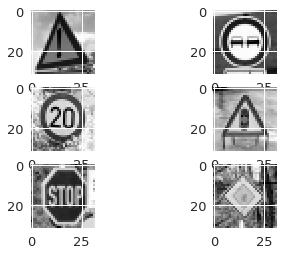

In [20]:

X_data=np.array(loadImages(6))
y_labels=np.array([18,11,14,12,9,0])


### Analyze Performance

In [22]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
    
### the accuracy on the test set should be calculated and reported as well.
# for i, result in enumerate(results):
#     print('{:02d}: Prediction {:02d}'.format(new_images_label[i], result))
# print('Accuracy: {:.02f}'.format(np.sum(new_images_label==results)/len(new_images_label)))

softmax = tf.nn.softmax(logits)
pred = tf.nn.top_k(softmax, 5)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
   
    result = sess.run(pred, feed_dict={x: X_data, keep_prob: 3})
    webaccuracy = evaluate(X_data, y_labels)

    predicted_logits = sess.run(logits, feed_dict={x:X_data, keep_prob:1})
    predicted_labels = np.argmax(predicted_logits, axis=1)

    predicted_labels= result.indices
    predictions  = result.values
print(predictions)
print(predicted_labels)

INFO:tensorflow:Restoring parameters from ./lenet
[[  9.90001202e-01   6.48571039e-03   3.43281450e-03   8.02556533e-05
    4.14603107e-09]
 [  1.00000000e+00   2.50738910e-13   1.43724103e-13   1.66392952e-15
    2.13752834e-17]
 [  9.87403989e-01   1.23171974e-02   2.78691121e-04   1.09222327e-07
    1.56109987e-08]
 [  9.99457896e-01   5.37084241e-04   4.52760514e-06   3.89838362e-07
    4.75625619e-08]
 [  8.21916163e-01   1.28178760e-01   4.98672575e-02   2.92729401e-05
    7.26710323e-06]
 [  9.99999881e-01   1.13084049e-07   4.37006911e-08   3.90711685e-09
    1.28823385e-09]]
[[26 22 18 25 24]
 [ 9 10 16 41 36]
 [ 0  1  3 16  2]
 [18 38 12 24 29]
 [14 38 39 13  1]
 [12  2 25 13 11]]


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

In [ ]:
with tf.Session() as sess:
    # Convolution (layer 1 after 'tf.nn.conv2d' operation)
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    conv1 = sess.graph.get_tensor_by_name('conv1:0')
    outputFeatureMap(X_web, conv1)
    #plt.savefig('05-conv1.png')